# Analyze the Diversity PCA

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [53]:
min_snp = 20000
path_pca = "./output/pca/v54.1var/20230424.varPCA.v54.1.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv"

savepath="" #"./output/pca/v54.1/pcs_meta.tsv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
#df = remove_individuals(df, remove_list=["_d"])
df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "clst", "region"]]
df = pd.merge(df, df2, on="iid", how="left")
df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

### Add Individuals from Punic project
df1 = pd.read_csv("./data/cluster_assignments_punic.v54.1c.tsv", sep="\t")
iids_anc2 = df1["iid"].values
print(f"Extracted IIDs of {len(iids_anc2)} IIDs in Punic Project")
df_punic = pd.merge(df, df1, on="iid", how="right")
print(f"Merged to {len(df_punic)} Punic IIDs")

Filtered to 3586 Individuals based on Min SNP: 20000
Filtered to 3586 based on duplicates
Filtered to 3586 based on manual removals
Extracted IIDs of 157 IIDs in Punic Project
Merged to 157 Punic IIDs


In [8]:
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], -df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, -df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")  
            
def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

Found ['keep_ho'] (exact): 1150/3586


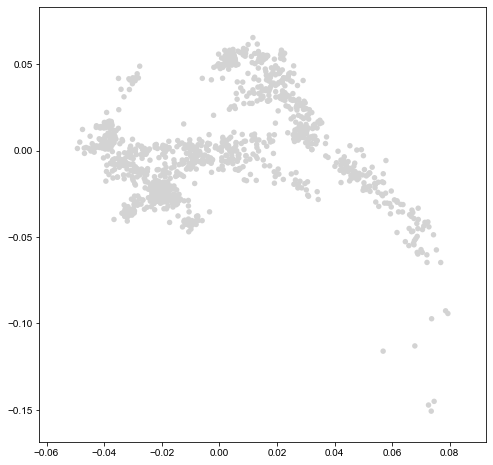

In [9]:
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["keep_ho"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

Found ['keep_ho'] (exact): 1132/3411


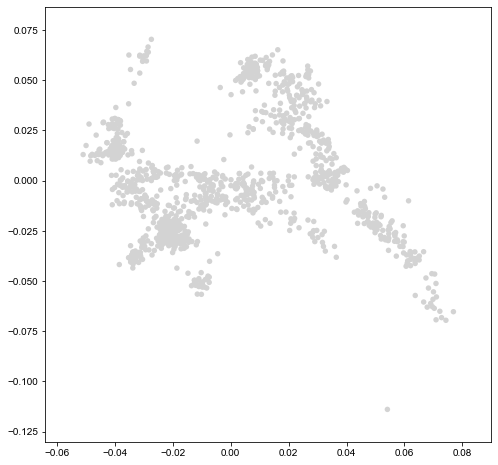

In [16]:
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["keep_ho"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [9]:
df["pop"].value_counts()

keep_anc    2279
keep_ho     1132
Name: pop, dtype: int64

# Organize samples from each site

In [10]:
df_anc = df[df["pop"]=="keep_anc"]

In [11]:
df_anc["loc"].value_counts()

Bohemia, Mikulovice                                                                           88
Murcia, Pliego, La Almoloya                                                                   66
Kamennyi Ambar 5 Cemetery                                                                     47
England, North Yorkshire, Vale of Pickering, West Heslerton                                   43
Roscommon, Kilteasheen                                                                        38
                                                                                              ..
Cádiz, San Fernando, Torre Alta                                                                1
Sicily, Marsala                                                                                1
Balearic Islands, Ibiza, Saint Antoni de Portmany, Can Portes d'es Jurat hipogeo Ca's Moli     1
Cádiz, Solar Los Chinchorros                                                                   1
Sicily, Marsala, Lilybaeum, vi

In [12]:
def get_sub_df_region(df, region="", min_n=10):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_reg = df[df["region"].isin(region)]
    cts = df_reg["loc"].value_counts()
    sites = cts[cts>=min_n].index.values
    
    df_res = create_pca_div_df(df, sites=sites)
    return df_res

def create_pca_div_df(df, sites=[], min_n=10):
    """Take Meta Data as input, and for each site calculates
    the Simpson Index of Y chromosomes"""
    data = []
    
    for s in sites:
        dft = df[df["loc"]==s] # Extract Site df 
        m = len(dft)
        if m==0:
            raise RuntimeWarning(f"Site {s} has no matching samples")
        
        if m >= min_n: # Calculate Variance
            vars2 = np.var(dft[["pc1", "pc2"]], axis=0)
            var = np.sum(vars2)
            age = np.median(dft["age"]) # Get the median Age
            data.append([s, age, m, var]) 
        else:
            continue
    
    # Make the summary Data Frame
    df_res = pd.DataFrame(data)
    df_res.columns = ["loc", "age", "n", "var"]
    return df_res

In [13]:
get_sub_df_region(df_anc, region=["Italy"])

,loc,age,n,var
0,"Piedmont, Collegno",1345.0,22,0.000238
1,Isola Sacra,1750.0,20,0.000441
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.000072
3,"Basilicata, Potenza, Venosa",1250.0,14,0.000129
4,"Sardinia, Tharros",2272.0,14,0.000733
5,"Sicily, Birgi",2473.5,12,0.000241
6,Villa Magna,595.0,12,0.000147
7,Tarquinia Monterozzi,2238.5,10,0.000591
8,"Tuscany, Grosseto, Casenovole",2350.0,10,0.000022


# Do the actual Plot

In [47]:
df_y_it = get_sub_df_region(df_anc, ["Italy"], min_n=10)
df_y_fr = get_sub_df_region(df_anc, ["France", "Germany", "Austria"], min_n=10)
df_y_ib = get_sub_df_region(df_anc, ["Spain", "Portugal"], min_n=10)
df_y_lev = get_sub_df_region(df_anc, ["Israel", "Lebanon"], min_n=10)
#df_y_ib = get_sub_df_region(["Spain", "Portugal"])

df_y_pun = create_pca_div_df(df_anc, sites=["Kerkouane", "Sardinia, Tharros",  "Sicily, Selinunte, Manuzza", "Sicily, Birgi", 
                                            'Almería, Cuevas del Almazora, Villaricos', "Tunis, Carthage",
                                            "Cap Bon, Kelibia"], min_n=7) # 
#df_y_him = create_pca_div_df(df_anc, sites=["Sicily, Himera"], min_n=10)

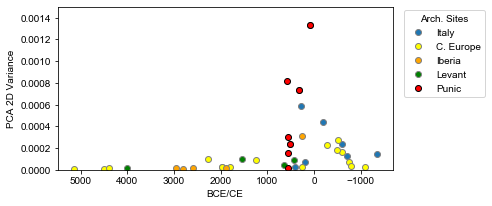

In [48]:
epsilon=0.0

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.scatter(df_y_it["age"]-1950, df_y_it["var"]+epsilon, ec="gray", label="Italy")
ax.scatter(df_y_fr["age"]-1950, df_y_fr["var"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax.scatter(df_y_ib["age"]-1950, df_y_ib["var"]+epsilon, c="orange", ec="gray", label="Iberia")
ax.scatter(df_y_lev["age"]-1950, df_y_lev["var"]+epsilon, c="green", ec="gray", label="Levant")
ax.scatter(df_y_pun["age"]-1950, df_y_pun["var"]+epsilon, ec="k", c="red", label="Punic")
#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")

ax.set_ylabel("PCA 2D Variance")
ax.set_xlabel("BCE/CE")
ax.invert_xaxis()
ax.legend(loc="upper left", title="Arch. Sites", bbox_to_anchor=(1.02, 1.01))
#ax.set_yscale('squareroot')
ax.set_ylim([0,0.0015])
plt.show()

In [44]:
df_y_it.sort_values(by="var")

,loc,age,n,var
8,"Tuscany, Grosseto, Casenovole",2350.0,10,0.000022
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.000072
3,"Basilicata, Potenza, Venosa",1250.0,14,0.000129
6,Villa Magna,595.0,12,0.000147
0,"Piedmont, Collegno",1345.0,22,0.000238
5,"Sicily, Birgi",2473.5,12,0.000241
1,Isola Sacra,1750.0,20,0.000441
7,Tarquinia Monterozzi,2238.5,10,0.000591
4,"Sardinia, Tharros",2272.0,14,0.000733


In [45]:
df_y_pun

,loc,age,n,var
0,Kerkouane,2533.0,10,0.000815
1,"Sardinia, Tharros",2272.0,14,0.000733
2,"Sicily, Birgi",2473.5,12,0.000241
3,"Almería, Cuevas del Almazora, Villaricos",2046.5,10,0.001334
4,"Tunis, Carthage",2500.0,14,0.000155
5,"Cap Bon, Kelibia",2500.0,8,0.000019


# Area 51

In [46]:
df_anc[df_anc["loc"].str.contains("Sicily, Selinunte, Manuzza")]["loc"].value_counts()

Sicily, Selinunte, Manuzza    7
Name: loc, dtype: int64

In [123]:
df_anc[df_anc["loc"].str.contains("Tarquinia Monterozzi")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst,region
121,R10361.SG,0.018501,-0.019929,0.008697,-0.002149,keep_anc,R10361,Tarquinia Monterozzi,940475.0,0.783729,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
582,R10342.SG,0.026318,-0.015178,-0.001976,-0.000712,keep_anc,R10342,Tarquinia Monterozzi,786219.0,0.655183,M,2044.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
677,R10343.SG,0.011269,-0.013103,0.015169,-0.004025,keep_anc,R10343,Tarquinia Monterozzi,763790.0,0.636492,F,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
698,R10363.SG,0.015554,-0.025272,0.008580,-0.001770,keep_anc,R10363,Tarquinia Monterozzi,758416.0,0.632013,M,2253.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
712,R10338.SG,0.014412,-0.026537,0.007785,-0.000641,keep_anc,R10338,Tarquinia Monterozzi,754348.0,0.628623,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
726,R10359.SG,0.015206,-0.026961,0.013146,-0.004550,keep_anc,R10359,Tarquinia Monterozzi,751224.0,0.626020,F,2224.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
813,R10337.SG,-0.035047,-0.000236,0.008281,-0.000090,keep_anc,R10337,Tarquinia Monterozzi,726431.0,0.605359,M,2028.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA_oLevent.SG,Italy
881,R10340.SG,0.018166,-0.021824,0.007920,-0.006685,keep_anc,R10340,Tarquinia Monterozzi,709616.0,0.591347,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
893,R10341.SG,-0.033897,0.007572,0.006198,-0.002651,keep_anc,R10341,Tarquinia Monterozzi,707028.0,0.589190,M,2054.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA_oLevent.SG,Italy
1345,R10339.SG,0.032835,-0.001707,-0.019000,-0.003498,keep_anc,R10339,Tarquinia Monterozzi,519536.0,0.432947,M,2054.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy


In [37]:
df_anc[df_anc["loc"].str.contains("Villaricos")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst,region
237,I18201,-0.010552,0.009523,0.017807,-0.003647,keep_anc,I18201,"Almería, Cuevas del Almazora, Villaricos",881415.0,0.734513,M,2554.0,"Lalueza-Fox, Carles",Spain_Punic_o.3rd.degree.relative.cluster_alt,Spain
804,I18199,-0.011248,0.008110,0.017801,-0.002228,keep_anc,I18199,"Almería, Cuevas del Almazora, Villaricos",744521.0,0.620434,M,2226.0,"Lalueza-Fox, Carles",Spain_Punic_o.3rd.degree.relative.cluster,Spain
1274,I18193,-0.067650,0.082703,-0.066391,-0.044774,keep_anc,I18193,"Almería, Cuevas del Almazora, Villaricos",603426.0,0.502855,M,2218.0,"Lalueza-Fox, Carles",Spain_Punic_Late_oAfrica,Spain
1298,I18203,-0.007620,0.013046,0.020195,-0.005619,keep_anc,I18203,"Almería, Cuevas del Almazora, Villaricos",591457.0,0.492881,F,2225.0,"Lalueza-Fox, Carles",Spain_Punic_Late,Spain
1626,I18400,-0.037778,0.051541,-0.027300,-0.026086,keep_anc,I18400,"Almería, Cuevas del Almazora, Villaricos",427507.0,0.356256,F,1585.0,"Lalueza-Fox, Carles",Spain_Vandal_Visigoth_oAfrica1,Spain
1683,I18189,-0.046866,0.064021,-0.032141,-0.026642,keep_anc,I18189,"Almería, Cuevas del Almazora, Villaricos",391907.0,0.326589,M,2221.0,"Lalueza-Fox, Carles",Spain_Punic_Late_oAfrica,Spain
1790,I18191,0.002626,0.025621,0.029622,-0.007404,keep_anc,I18191,"Almería, Cuevas del Almazora, Villaricos",321531.0,0.267943,F,1875.0,"Lalueza-Fox, Carles",Spain_Punic_Roman_oEuropean2,Spain
1882,I18200,-0.010606,0.022618,0.012185,-0.005803,keep_anc,I18200,"Almería, Cuevas del Almazora, Villaricos",265104.0,0.220920,F,1875.0,"Lalueza-Fox, Carles",Spain_Punic_Roman_o3,Spain
2002,I18198,-0.061118,0.084521,-0.055642,-0.040338,keep_anc,I18198,"Almería, Cuevas del Almazora, Villaricos",190733.0,0.158944,F,1850.0,"Lalueza-Fox, Carles",Spain_Roman_oAfrica2,Spain
2340,I18205,-0.011407,0.033741,0.002204,-0.017330,keep_anc,I18205,"Almería, Cuevas del Almazora, Villaricos",59142.0,0.049285,F,1875.0,"Lalueza-Fox, Carles",Spain_Punic_Roman_oAfrica3,Spain


In [38]:
df_punic = df_anc[df_anc["clst"].str.contains("Punic")]